In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [ ]:
# Load the data from the uploaded file
file_path = '/content/Data.xlsx'
data = pd.ExcelFile(file_path)

# Inspect the sheet names to understand the structure of the file
data.sheet_names

['Unemployment', 'GDP']

In [ ]:
# Load the "Unemployment" sheet
unemployment_monthly = data.parse('Unemployment')

# Display the first few rows of the unemployment data
unemployment_monthly.head()

,observation_date,Unemployment_rate
0,1967-01-01,1.6
1,1967-02-01,1.6
2,1967-03-01,1.5
3,1967-04-01,1.6
4,1967-05-01,1.6


In [ ]:
# Load the "Unemployment" sheet
gdp_quarterly = data.parse('GDP')

# Display the first few rows of the unemployment data
gdp_quarterly.head()

,observation_date,real_GDP
0,1961-01-01,90980.796875
1,1961-04-01,93284.500000
2,1961-07-01,95554.500000
3,1961-10-01,96854.500000
4,1962-01-01,99431.796875


In [ ]:
unemployment_monthly = pd.read_excel(file_path, sheet_name='Unemployment')
unemployment_monthly['observation_date'] = pd.to_datetime(unemployment_monthly['observation_date'])

gdp_quarterly = pd.read_excel(file_path, sheet_name='GDP')
gdp_quarterly['observation_date'] = pd.to_datetime(gdp_quarterly['observation_date'])

In [ ]:
unemployment_monthly.set_index('observation_date', inplace=True)
gdp_quarterly.set_index('observation_date', inplace=True)

# Downsample unemployment rate to quarterly
unemployment_quarterly = unemployment_monthly.resample('QE').mean()
gdp_quarterly.index = gdp_quarterly.index.to_period('Q').to_timestamp(how='end')
gdp_quarterly.index = gdp_quarterly.index.normalize()

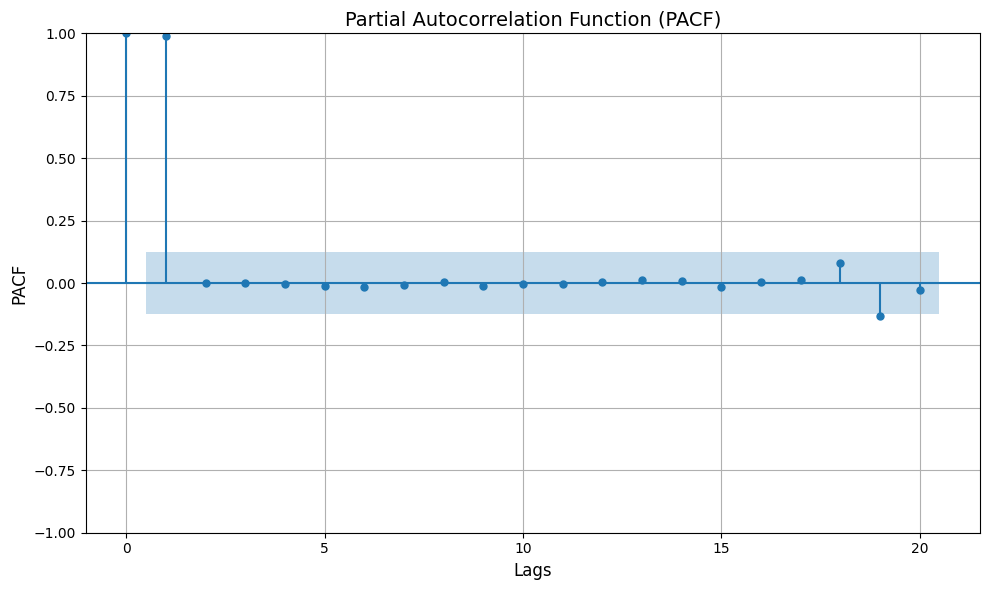

In [ ]:
# Plot the Partial Autocorrelation Function (PACF)
fig, ax = plt.subplots(figsize=(10, 6))
plot_pacf(gdp_quarterly, ax=ax, lags=20, method='ywmle')  # Adjust lags as needed
ax.set_title('Partial Autocorrelation Function (PACF)', fontsize=14)
ax.set_xlabel('Lags', fontsize=12)
ax.set_ylabel('PACF', fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.savefig("pacf_gdp.jpg", dpi=300, bbox_inches="tight")
plt.show()

In [ ]:
unemp = unemployment_quarterly.iloc[:-1]
gdp = gdp_quarterly.iloc[24:]

In [ ]:
gdp

,real_GDP,Deseasonalized_GDP
observation_date,,
1967-03-31,130512.796875,130004.918038
1967-06-30,133231.796875,133617.612374
1967-09-30,133651.796875,133992.665976
1967-12-31,134234.000000,134567.800163
1968-03-31,135378.296875,135113.355321
...,...,...
2023-09-30,588909.500000,588587.844289
2023-12-31,589018.500000,588290.278100
2024-03-31,591591.812500,591083.933663


In [ ]:
correlation = unemp['Unemployment_rate'].corr(gdp['real_GDP'])

print(f"Pearson correlation between unemployment rate and GDP: {correlation}")

Pearson correlation between unemployment rate and GDP: 0.00826023968089542


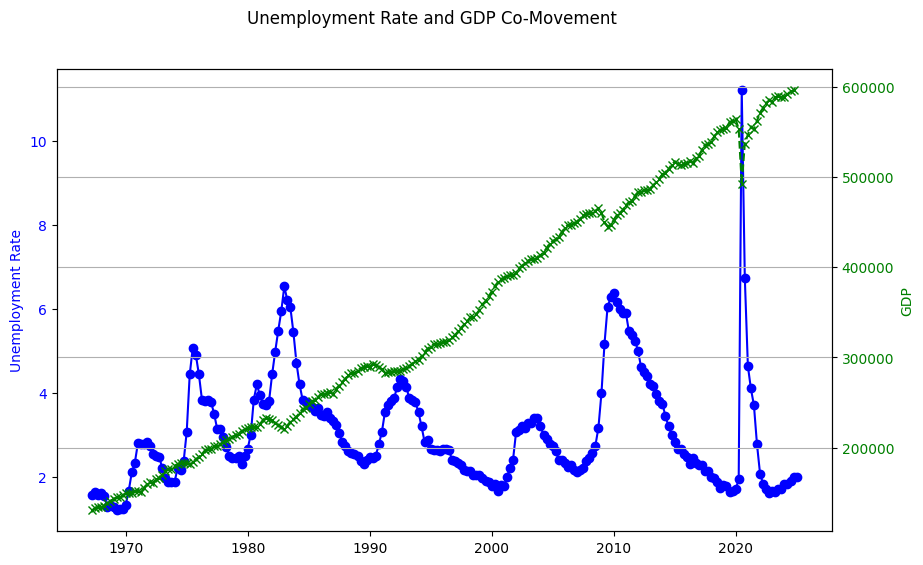

In [ ]:
fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.plot(unemployment_quarterly, label='Unemployment Rate', color='blue', marker='o')
ax1.set_ylabel('Unemployment Rate', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

ax2 = ax1.twinx()
ax2.plot(gdp, label='GDP', color='green', linestyle='--', marker='x')
ax2.set_ylabel('GDP', color='green')
ax2.tick_params(axis='y', labelcolor='green')

fig.suptitle('Unemployment Rate and GDP Co-Movement')
plt.grid()
plt.savefig("gdp_vs_unemp.jpg", dpi=300, bbox_inches="tight")
plt.show()


In [ ]:
# Example: Slice GDP data for specific quarters
start_date_q = pd.to_datetime('1992Q1')
end_date_q = pd.to_datetime('1995Q4')

gdp_sliced = gdp.loc[start_date_q:end_date_q]
unemp_sliced = unemp.loc[start_date_q:end_date_q]
unemp_sliced['Unemployment_rate'].corr(gdp_sliced['real_GDP'])

-0.9869774850696837

In [ ]:
from statsmodels.tsa.stattools import adfuller

# Step 1: Check Stationarity
def check_stationarity(series, name):
    result = adfuller(series.dropna())
    print(f'{name} Stationarity Test:')
    print(f'ADF Statistic: {result[0]:.2f}')
    print(f'p-value: {result[1]:.4f}')
    print('Stationary' if result[1] < 0.05 else 'Non-stationary')

check_stationarity(gdp, 'real_GDP')

real_GDP Stationarity Test:
ADF Statistic: 0.57
p-value: 0.9869
Non-stationary


In [ ]:
gdp_diff = gdp.diff().dropna()
check_stationarity(gdp_diff, 'real_GDP')

real_GDP Stationarity Test:
ADF Statistic: -12.40
p-value: 0.0000
Stationary


# Model

GDP Stationarity Test:
ADF Statistic: 0.57
p-value: 0.9869
Non-stationary
Unemployment Rate Stationarity Test:
ADF Statistic: -4.49
p-value: 0.0002
Stationary


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  207
Model:             SARIMAX(1, 0, 0)x(2, 2, [1], 12)   Log Likelihood                 656.087
Date:                              Tue, 21 Jan 2025   AIC                          -1300.175
Time:                                      01:35:30   BIC                          -1280.918
Sample:                                           0   HQIC                         -1292.369
                                              - 207                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0097      0.001    -11.244      0.000      -0.011      -0.008
ar.L1          0.92

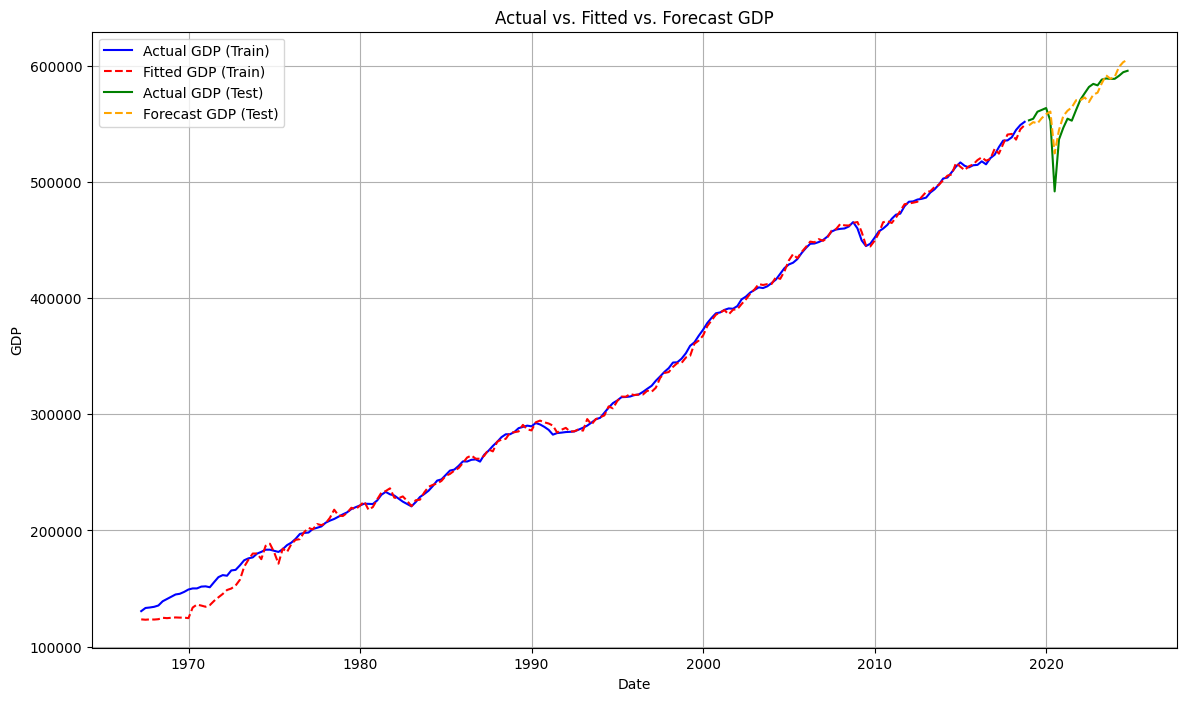

Mean Absolute Error on Test Data: 96281776.87


In [ ]:
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler


# Step 1: Check Stationarity
def check_stationarity(series, name):
    result = adfuller(series.dropna())
    print(f'{name} Stationarity Test:')
    print(f'ADF Statistic: {result[0]:.2f}')
    print(f'p-value: {result[1]:.4f}')
    print('Stationary' if result[1] < 0.05 else 'Non-stationary')

# Check stationarity for both series
check_stationarity(gdp['real_GDP'], 'GDP')
check_stationarity(unemp['Unemployment_rate'], 'Unemployment Rate')

# Step 2: Train-Test Split
train_size = int(len(gdp) * 0.9)

# Step 3: Normalize Data
scaler_gdp = MinMaxScaler()
gdp_normalized = scaler_gdp.fit_transform(gdp['real_GDP'].values.reshape(-1, 1)).flatten()

# Training and test variables
y_train = gdp_normalized[:train_size]
X_train = unemp['Unemployment_rate'].iloc[:train_size].reset_index(drop=True).values.reshape(-1, 1)
y_test = gdp_normalized[train_size:]
X_test = unemp['Unemployment_rate'].iloc[train_size:].reset_index(drop=True).values.reshape(-1, 1)

# Step 4: Fit SARIMAX Model
model = sm.tsa.SARIMAX(y_train, exog=X_train, seasonal_order=(2, 2, 1, 12))
results = model.fit()

# Print model summary
print(results.summary())

# Step 5: Forecast on Test Data
forecast_normalized = results.forecast(steps=len(y_test), exog=X_test)

# Step 6: Denormalize Data
fitted_denormalized = scaler_gdp.inverse_transform(results.fittedvalues.reshape(-1, 1)).flatten()
forecast_denormalized = scaler_gdp.inverse_transform(forecast_normalized.reshape(-1, 1)).flatten()
y_train_denormalized = scaler_gdp.inverse_transform(y_train.reshape(-1, 1)).flatten()
y_test_denormalized = scaler_gdp.inverse_transform(y_test.reshape(-1, 1)).flatten()

# Step 7: Plot Results
plt.figure(figsize=(14, 8))
plt.plot(gdp.index[:train_size], y_train_denormalized, label='Actual GDP (Train)', color='blue')
plt.plot(gdp.index[:train_size], fitted_denormalized, label='Fitted GDP (Train)', color='red', linestyle='--')
plt.plot(gdp.index[train_size:], y_test_denormalized, label='Actual GDP (Test)', color='green')
plt.plot(gdp.index[train_size:], forecast_denormalized, label='Forecast GDP (Test)', color='orange', linestyle='--')
plt.title('Actual vs. Fitted vs. Forecast GDP')
plt.xlabel('Date')
plt.ylabel('GDP')
plt.legend()
plt.grid()
plt.savefig("forecast_gdp.jpg", dpi=300, bbox_inches="tight")
plt.show()

# Step 8: Evaluate Model Performance
mse = mean_squared_error(y_test_denormalized, forecast_denormalized)
print(f"Mean Absolute Error on Test Data: {mse:.2f}")

sforecast = forecast_denormalized

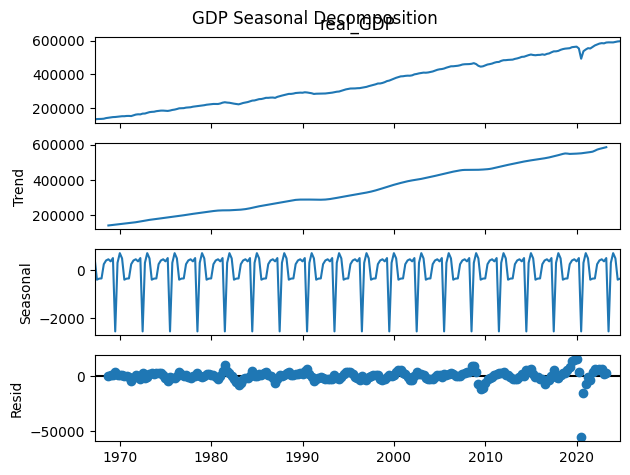

<ipython-input-13-1cf05c43cd1f>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gdp['Deseasonalized_GDP'] = deseasonalize(gdp['real_GDP'], freq, 'GDP')


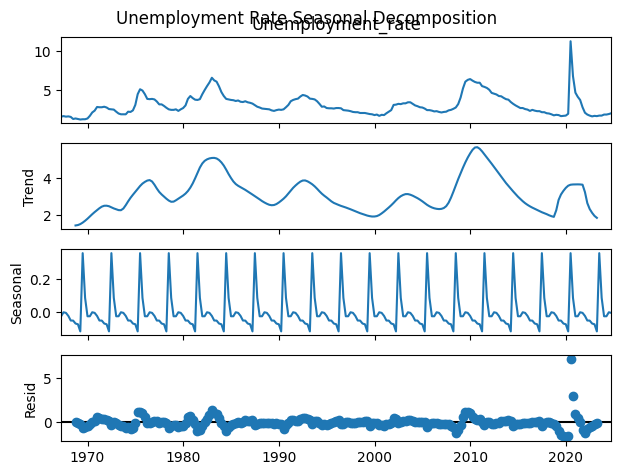

<ipython-input-13-1cf05c43cd1f>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unemp['Deseasonalized_Unemployment'] = deseasonalize(unemp['Unemployment_rate'], freq, 'Unemployment Rate')


Deseasonalized GDP Stationarity Test:
ADF Statistic: 0.59
p-value: 0.9874
Non-stationary
Deseasonalized Unemployment Rate Stationarity Test:
ADF Statistic: -4.40
p-value: 0.0003
Stationary
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  207
Model:               SARIMAX(2, 2, 1)   Log Likelihood                 824.869
Date:                Tue, 21 Jan 2025   AIC                          -1639.737
Time:                        01:35:46   BIC                          -1623.122
Sample:                    03-31-1967   HQIC                         -1633.017
                         - 09-30-2018                                         
Covariance Type:                  opg                                         
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------

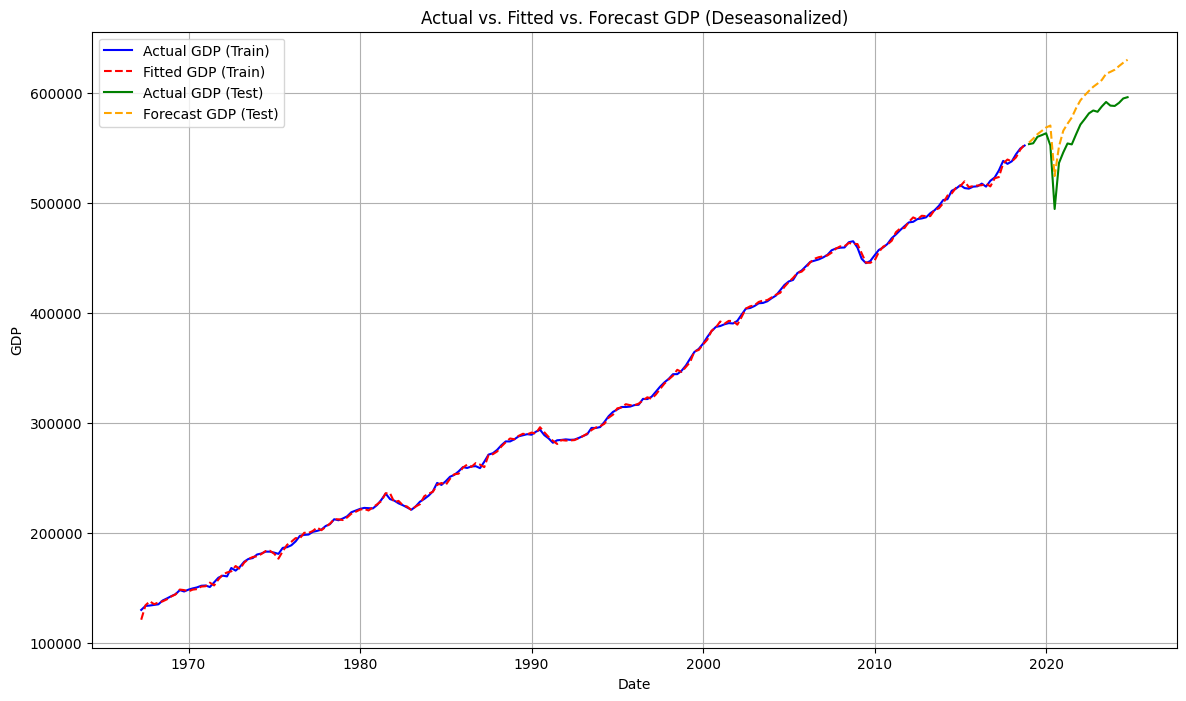

Mean Absolute Error on Test Data: 519747698.27


In [ ]:
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

# Assume `gdp` and `unemp` are pandas DataFrames with columns 'real_GDP' and 'Unemployment_rate'

# Step 1: Deseasonalize Data
def deseasonalize(series, freq, name):
    decomposition = seasonal_decompose(series, model='additive', period=freq)
    deseasonalized = series - decomposition.seasonal
    # Plot seasonal decomposition
    decomposition.plot()
    plt.suptitle(f'{name} Seasonal Decomposition')
    plt.savefig(f"{name}_seasonal_decomposition.jpg", dpi=300, bbox_inches="tight")
    plt.show()
    return deseasonalized

# Deseasonalize GDP and Unemployment Rate
freq = 12  # Example: Monthly data (adjust based on your dataset frequency)
gdp['Deseasonalized_GDP'] = deseasonalize(gdp['real_GDP'], freq, 'GDP')
unemp['Deseasonalized_Unemployment'] = deseasonalize(unemp['Unemployment_rate'], freq, 'Unemployment Rate')

# Step 2: Check Stationarity
def check_stationarity(series, name):
    result = adfuller(series.dropna())
    print(f'{name} Stationarity Test:')
    print(f'ADF Statistic: {result[0]:.2f}')
    print(f'p-value: {result[1]:.4f}')
    print('Stationary' if result[1] < 0.05 else 'Non-stationary')

# Check stationarity for both deseasonalized series
check_stationarity(gdp['Deseasonalized_GDP'], 'Deseasonalized GDP')
check_stationarity(unemp['Deseasonalized_Unemployment'], 'Deseasonalized Unemployment Rate')

# Step 3: Normalize the Data
scaler_gdp = MinMaxScaler()
gdp_normalized = scaler_gdp.fit_transform(gdp['Deseasonalized_GDP'].dropna().values.reshape(-1, 1)).flatten()

# Train-Test Split
train_size = int(len(gdp) * 0.9)
y_train = gdp_normalized[:train_size]
X_train = unemp['Deseasonalized_Unemployment'].iloc[:train_size]
y_test = gdp_normalized[train_size:]
X_test = unemp['Deseasonalized_Unemployment'].iloc[train_size:]

# Step 4: Fit the SARIMAX Model
model = sm.tsa.SARIMAX(y_train, exog=X_train, order=(2, 2, 1))
results = model.fit()

# Print model summary
print(results.summary())

# Step 5: Forecast on Test Data
forecast_normalized = results.forecast(steps=len(y_test), exog=X_test)

# Step 6: Denormalize Data
fitted_denormalized = scaler_gdp.inverse_transform(results.fittedvalues.values.reshape(-1, 1)).flatten()
forecast_denormalized = scaler_gdp.inverse_transform(forecast_normalized.values.reshape(-1, 1)).flatten()
y_train_denormalized = scaler_gdp.inverse_transform(y_train.reshape(-1, 1)).flatten()
y_test_denormalized = scaler_gdp.inverse_transform(y_test.reshape(-1, 1)).flatten()

# Step 7: Plot Results
plt.figure(figsize=(14, 8))

# Training Data and Fitted Values
plt.plot(X_train.index, y_train_denormalized, label='Actual GDP (Train)', color='blue')
plt.plot(X_train.index, fitted_denormalized, label='Fitted GDP (Train)', color='red', linestyle='--')

# Test Data and Forecast
plt.plot(X_test.index, y_test_denormalized, label='Actual GDP (Test)', color='green')
plt.plot(X_test.index, forecast_denormalized, label='Forecast GDP (Test)', color='orange', linestyle='--')

# Labels, Legend, and Grid
plt.title('Actual vs. Fitted vs. Forecast GDP (Deseasonalized)')
plt.xlabel('Date')
plt.ylabel('GDP')
plt.legend()
plt.grid()
plt.savefig("deseasonalized_forecast_gdp.jpg", dpi=300, bbox_inches="tight")
plt.show()

# Step 8: Evaluate Model Performance
mse = mean_squared_error(y_test_denormalized, forecast_denormalized)
print(f"Mean Absolute Error on Test Data: {mse:.2f}")

deseason_arimax = forecast_denormalized


In [ ]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:               real_GDP   No. Observations:                  207
Model:               SARIMAX(2, 2, 1)   Log Likelihood                 851.995
Date:                Sun, 19 Jan 2025   AIC                          -1693.989
Time:                        16:20:58   BIC                          -1677.374
Sample:                    03-31-1967   HQIC                         -1687.269
                         - 09-30-2018                                         
Covariance Type:                  opg                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Unemployment_rate    -0.0910      0.008    -10.898      0.000      -0.107      -0.075
ar.L1                 0.2507      0.071      3.555      0.000       0.112       0.389
ar.L2                -0.1161      0.066     -1.766      0.077      -0.245       0.013
ma.L1                -0.9386      0.029    -32.287      0.000      -0.996      -0.882
sigma2             1.419e-05    1.4e-06     10.160      0.000    1.15e-05    1.69e-05
===================================================================================
Ljung-Box (L1) (Q):                   0.12   Jarque-Bera (JB):                 2.08
Prob(Q):                              0.73   Prob(JB):                         0.35
Heteroskedasticity (H):               2.24   Skew:                            -0.18
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.34
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

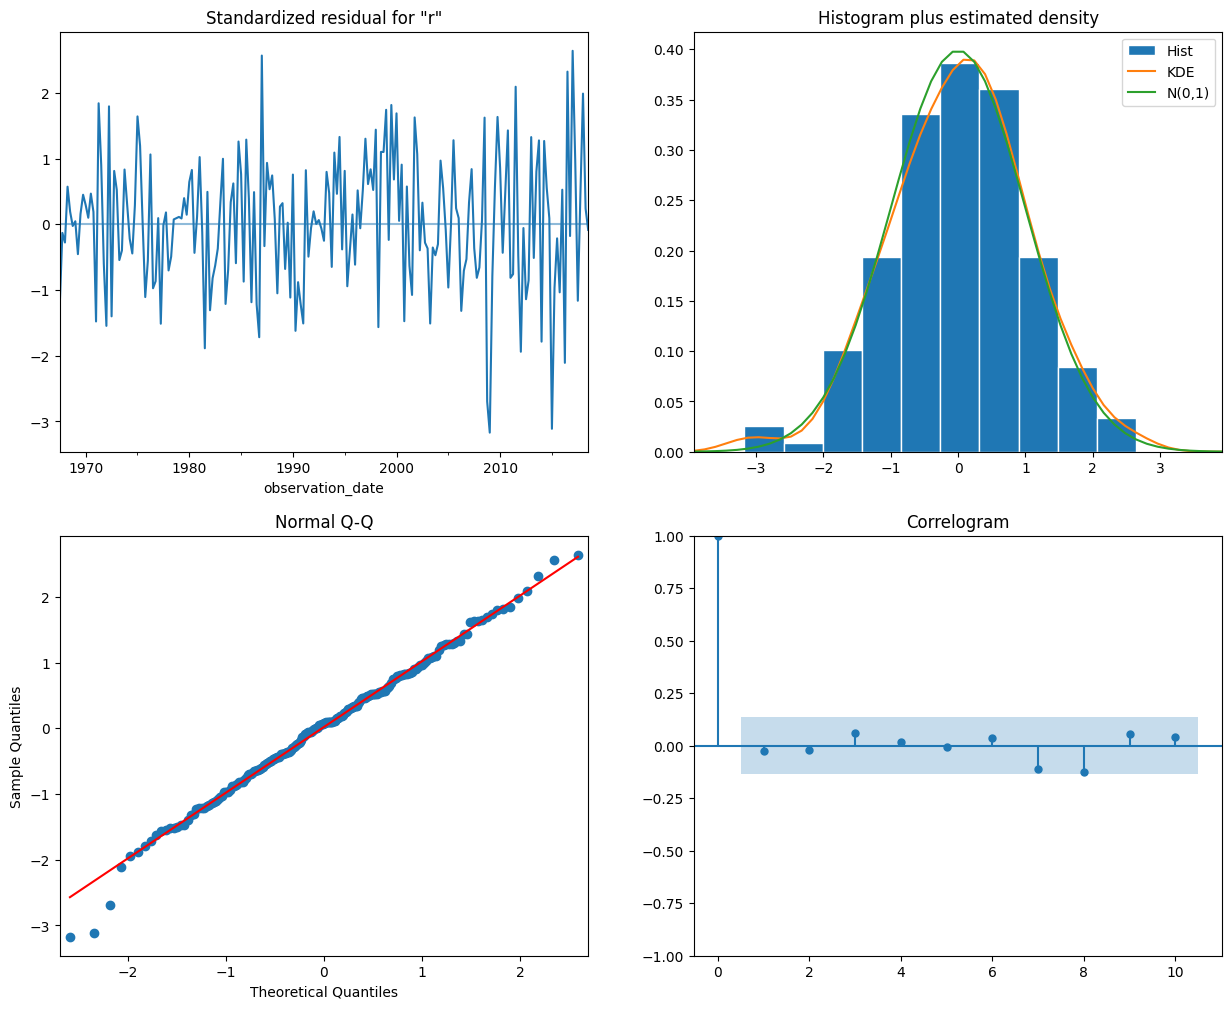

In [ ]:
results.plot_diagnostics(figsize=(15, 12))
plt.savefig("diagnostics.jpg", dpi=300, bbox_inches="tight")
plt.show()

## Granger Causality
The predictive power of the exogeneous variable

In [ ]:
from statsmodels.tsa.stattools import grangercausalitytests
grangercausalitytests(data_norm[['real_GDP', 'Unemployment_rate']], maxlag=2)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=17.4270 , p=0.0000  , df_denom=227, df_num=1
ssr based chi2 test:   chi2=17.6573 , p=0.0000  , df=1
likelihood ratio test: chi2=17.0123 , p=0.0000  , df=1
parameter F test:         F=17.4270 , p=0.0000  , df_denom=227, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=26.8730 , p=0.0000  , df_denom=224, df_num=2
ssr based chi2 test:   chi2=54.9456 , p=0.0000  , df=2
likelihood ratio test: chi2=49.2489 , p=0.0000  , df=2
parameter F test:         F=26.8730 , p=0.0000  , df_denom=224, df_num=2


{1: ({'ssr_ftest': (17.426963404583834, 4.255947168994728e-05, 227.0, 1),
   'ssr_chi2test': (17.65727569627437, 2.645015290666856e-05, 1),
   'lrtest': (17.01230158414137, 3.7138422360810425e-05, 1),
   'params_ftest': (17.426963404584537, 4.2559471689932105e-05, 227.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (26.87295307754698, 3.4613014224341055e-11, 224.0, 2),
   'ssr_chi2test': (54.9455915603416, 1.1714301300655239e-12, 2),
   'lrtest': (49.248885928070194, 2.021809816189521e-11, 2),
   'params_ftest': (26.87295307754734, 3.4613014224330916e-11, 224.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])])}

# MIDAS

In [ ]:
gdp

,real_GDP
observation_date,
1967-01-01,130512.796875
1967-04-01,133231.796875
1967-07-01,133651.796875
1967-10-01,134234.000000
1968-01-01,135378.296875
...,...
2023-07-01,588909.500000
2023-10-01,589018.500000
2024-01-01,591591.812500


In [ ]:
unemp

,x,y,z
observation_date,,,
1967-01-01,1.6,1.6,1.5
1967-04-01,1.6,1.6,1.7
1967-07-01,1.6,1.5,1.6
1967-10-01,1.6,1.6,1.6
1968-01-01,1.6,1.5,1.5
...,...,...,...
2023-07-01,1.6,1.8,1.7
2023-10-01,1.9,1.8,1.8
2024-01-01,1.8,1.9,1.8


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  207
Model:               SARIMAX(1, 2, 1)   Log Likelihood                 834.251
Date:                Tue, 21 Jan 2025   AIC                          -1656.502
Time:                        01:36:26   BIC                          -1636.564
Sample:                             0   HQIC                         -1648.437
                                - 207                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0562      0.019     -2.889      0.004      -0.094      -0.018
x2            -0.0013      0.023     -0.055      0.956      -0.047       0.045
x3            -0.0402      0.014     -2.971      0.0

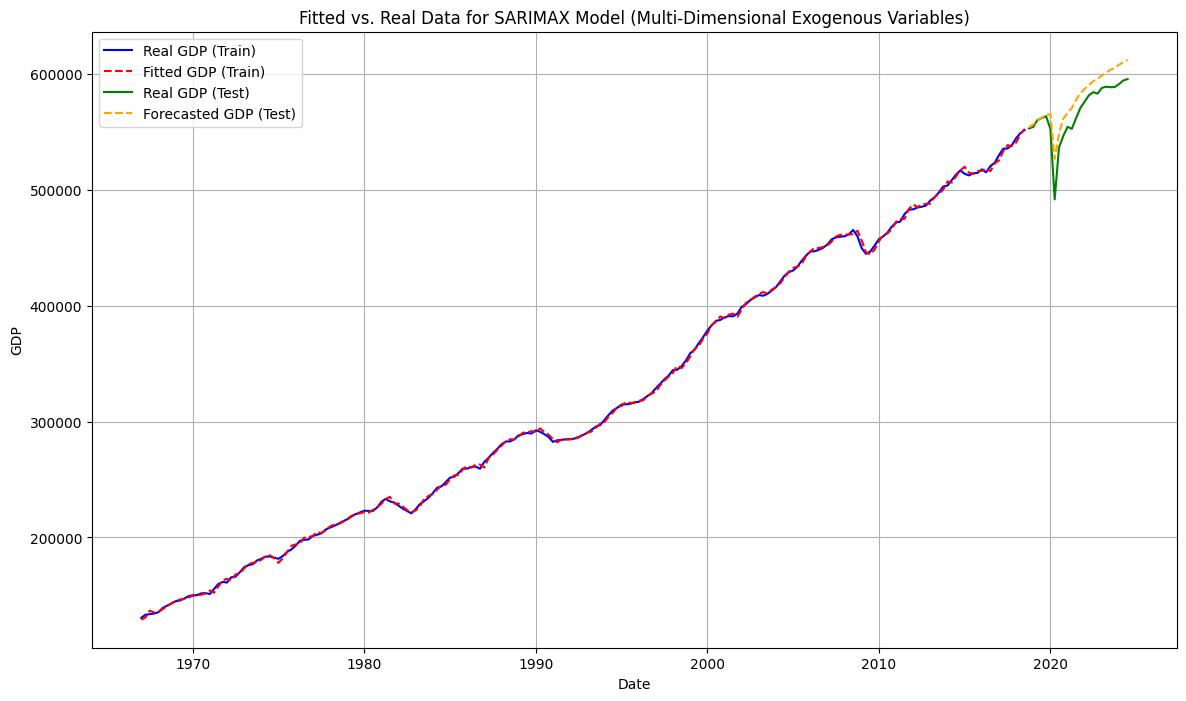

In [ ]:
data = pd.ExcelFile(file_path)
gdp = data.parse('GDP')
gdp.index = gdp['observation_date']
gdp.drop('observation_date', axis=1, inplace=True)
unemp = data.parse('Unemployment')
unemp.index = unemp['observation_date']
unemp.drop('observation_date', axis=1, inplace=True)

unemp['group'] = (unemp.index.month - 1) % 3 + 1
x = unemp[unemp['group']==1]['Unemployment_rate'].iloc[:-1]
y = unemp[unemp['group']==2]['Unemployment_rate'].iloc[:-1]
z = unemp[unemp['group']==3][ 'Unemployment_rate']
df = pd.DataFrame({'x':x.values, 'y':y.values, 'z':z.values})
df.index = x.index
unemp = df
gdp = gdp.iloc[24:]

# resample by quarter

from sklearn.preprocessing import MinMaxScaler

# Step 1: Normalize the Data
scaler_gdp = MinMaxScaler()
scaler_unemp = MinMaxScaler()

# Normalize GDP and Unemployment rate (column-wise for unemp)
gdp_normalized = scaler_gdp.fit_transform(gdp.values.reshape(-1, 1)).flatten()
unemp_normalized = scaler_unemp.fit_transform(unemp)

# Step 2: Train-Test Split
train_size = int(len(gdp_normalized) * 0.9)  # Use 90% for training

# Split normalized data
y_train = gdp_normalized[:train_size]
X_train = unemp_normalized[:train_size]
y_test = gdp_normalized[train_size:]
X_test = unemp_normalized[train_size:]

# Step 3: Fit the SARIMAX Model
model = sm.tsa.SARIMAX(y_train, exog=X_train, order=(1, 2, 1))
results = model.fit()

# Print model summary
print(results.summary())

# Step 4: Forecast on Test Data
forecast_normalized = results.forecast(steps=len(y_test), exog=X_test)

# Step 5: Denormalize Data
fitted_denormalized = scaler_gdp.inverse_transform(results.fittedvalues.reshape(-1, 1)).flatten()
forecast_denormalized = scaler_gdp.inverse_transform(forecast_normalized.reshape(-1, 1)).flatten()
y_train_denormalized = scaler_gdp.inverse_transform(y_train.reshape(-1, 1)).flatten()
y_test_denormalized = scaler_gdp.inverse_transform(y_test.reshape(-1, 1)).flatten()

# Step 6: Plot Fitted vs Real Data
plt.figure(figsize=(14, 8))

# Plot training data and fitted values
plt.plot(gdp.index[:train_size], y_train_denormalized, label="Real GDP (Train)", color="blue")
plt.plot(gdp.index[:train_size], fitted_denormalized, label="Fitted GDP (Train)", color="red", linestyle="--")

# Plot test data and forecasted values
plt.plot(gdp.index[train_size:], y_test_denormalized, label="Real GDP (Test)", color="green")
plt.plot(gdp.index[train_size:], forecast_denormalized, label="Forecasted GDP (Test)", color="orange", linestyle="--")

# Add labels, legend, and grid
plt.title("Fitted vs. Real Data for SARIMAX Model (Multi-Dimensional Exogenous Variables)")
plt.xlabel("Date")
plt.ylabel("GDP")
plt.legend()
plt.grid()
plt.savefig("fitted_vs_real_multivariate.jpg", dpi=300, bbox_inches="tight")
plt.show()

mixed = forecast_denormalized

In [ ]:
unemp = unemployment_quarterly.iloc[:-1]
gdp = gdp_quarterly.iloc[24:]

gdp.reset_index(inplace=True)

# Rename the columns for Prophet
gdp.rename(columns={'observation_date': 'ds', 'real_GDP': 'y'}, inplace=True)

# Ensure the 'ds' column is in datetime format
gdp['ds'] = pd.to_datetime(gdp['ds'])

# If unemployment is a separate DataFrame, merge it with the GDP data
# Assume `unemp` has the same index or a column called 'Date'
unemp.reset_index(inplace=True)
unemp.rename(columns={'observation_date': 'ds', 'Unemployment_rate': 'unemployment'}, inplace=True)
unemp['ds'] = pd.to_datetime(unemp['ds'])

# Merge GDP and Unemployment Data
data = pd.merge(gdp, unemp, on='ds', how='inner')

data

<ipython-input-16-f1bd24cbab02>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gdp.rename(columns={'observation_date': 'ds', 'real_GDP': 'y'}, inplace=True)
<ipython-input-16-f1bd24cbab02>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gdp['ds'] = pd.to_datetime(gdp['ds'])
<ipython-input-16-f1bd24cbab02>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unemp.rename(columns=

,ds,y,unemployment
0,1967-03-31,130512.796875,1.566667
1,1967-06-30,133231.796875,1.633333
2,1967-09-30,133651.796875,1.566667
3,1967-12-31,134234.000000,1.600000
4,1968-03-31,135378.296875,1.533333
...,...,...,...
226,2023-09-30,588909.500000,1.700000
227,2023-12-31,589018.500000,1.833333
228,2024-03-31,591591.812500,1.833333
229,2024-06-30,594729.312500,1.900000


In [ ]:
df = data[['ds', 'y', 'unemployment']]
df

,ds,y,unemployment
0,1967-03-31,130512.796875,1.566667
1,1967-06-30,133231.796875,1.633333
2,1967-09-30,133651.796875,1.566667
3,1967-12-31,134234.000000,1.600000
4,1968-03-31,135378.296875,1.533333
...,...,...,...
226,2023-09-30,588909.500000,1.700000
227,2023-12-31,589018.500000,1.833333
228,2024-03-31,591591.812500,1.833333
229,2024-06-30,594729.312500,1.900000


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfl__a4te/4fgz0qlo.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfl__a4te/xqpqjs7m.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=47022', 'data', 'file=/tmp/tmpfl__a4te/4fgz0qlo.json', 'init=/tmp/tmpfl__a4te/xqpqjs7m.json', 'output', 'file=/tmp/tmpfl__a4te/prophet_model46id9ovd/prophet_model-20250121013808.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
01:38:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
01:38:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Mean Squared Error on Test Data: 40358882.38


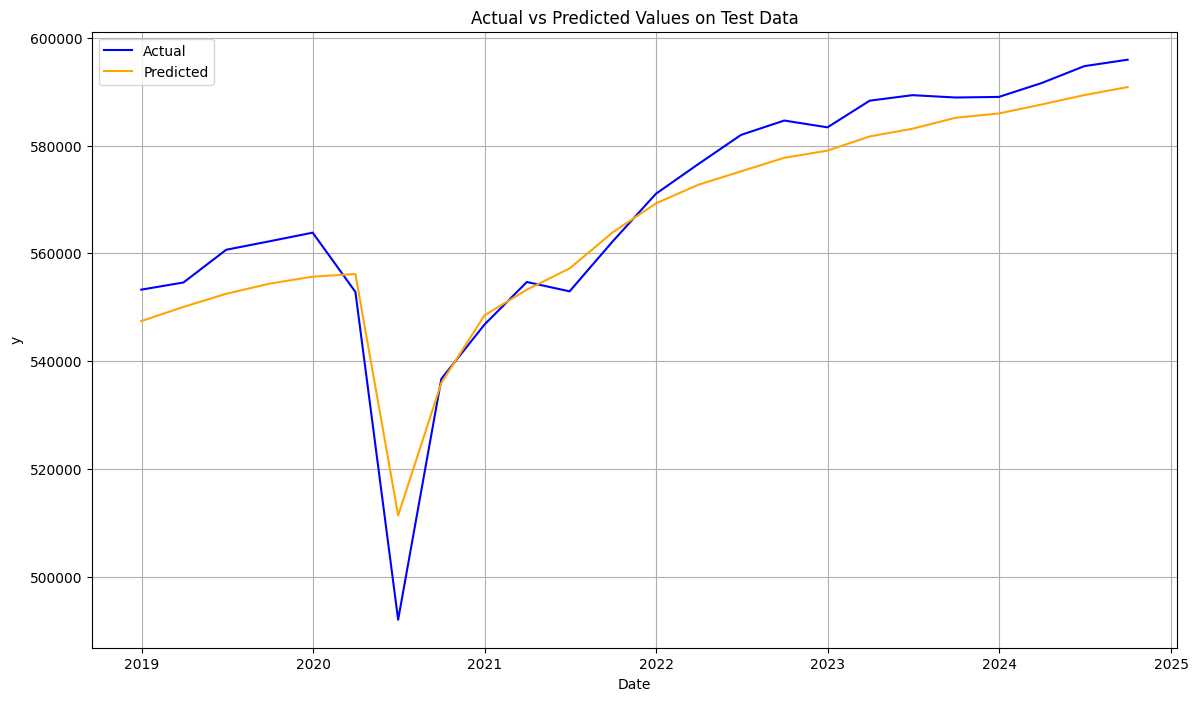

In [ ]:
from prophet import Prophet


# Step 1: Split the Data into Training and Testing Sets
train_size = int(len(df) * 0.9)  # Use 90% of the data for training
train_data = df.iloc[:train_size]
test_data = df.iloc[train_size:]

# Step 2: Initialize the Prophet Model with an Exogenous Variable
model = Prophet()
model.add_regressor('unemployment')  # Add the unemployment column as a regressor

# Step 3: Fit the Model to the Training Data
model.fit(train_data)

# Step 4: Create Future Dataframe for Predictions
# Use the test set for forecasting
future = test_data[['ds', 'unemployment']]

# Step 5: Predict on the Test Data
forecast = model.predict(future)

# Step 6: Evaluate Model Performance
# Extract the predicted and actual values
y_pred = forecast['yhat']
y_true = test_data['y']

# Compute Mean Squared Error
mse = mean_squared_error(y_true, y_pred)
print(f"Mean Squared Error on Test Data: {mse:.2f}")

# Step 7: Plot the Results
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 8))
plt.plot(test_data['ds'], y_true, label='Actual', color='blue')
plt.plot(test_data['ds'], y_pred, label='Predicted', color='orange')
plt.title('Actual vs Predicted Values on Test Data')
plt.xlabel('Date')
plt.ylabel('y')
plt.legend()
plt.grid()
plt.show()

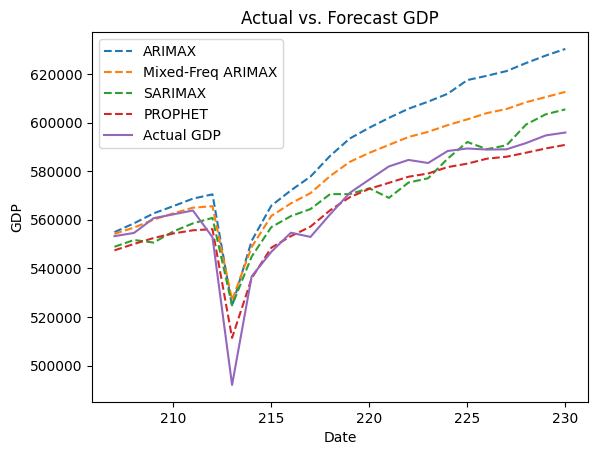

In [ ]:
plt.plot(gdp.index[train_size:], deseason_arimax, label="ARIMAX", linestyle='--')
plt.plot(gdp.index[train_size:], mixed, label="Mixed-Freq ARIMAX", linestyle='--')
plt.plot(gdp.index[train_size:], sforecast, label="SARIMAX", linestyle='--')
plt.plot(gdp.index[train_size:], y_pred, label="PROPHET", linestyle='--')
plt.plot(gdp.index[train_size:], y_test_denormalized, label="Actual GDP")
plt.title("Actual vs. Forecast GDP")
plt.xlabel("Date")
plt.ylabel("GDP")
plt.legend()
plt.savefig("all_forecast_gdp.jpg", dpi=300, bbox_inches="tight")
plt.show()

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

preds = [deseason_arimax, mixed, sforecast, y_pred]
errors = []
for pred in preds:
    mae = mean_absolute_error(y_test_denormalized, pred)
    mse = mean_squared_error(y_test_denormalized, pred)
    rmse = mse**0.5
    mape = np.mean(np.abs((y_test_denormalized - pred) / y_test_denormalized)) * 100
    errors.append({'rmse': rmse, 'mae': mae, 'mape': mape})

errors = pd.DataFrame(errors, index=['ARIMAX', 'Mixed-Freq ARIMAX', 'SARIMAX', 'PROPHET'])
errors

,rmse,mae,mape
ARIMAX,22905.548758,20434.399079,3.583113
Mixed-Freq ARIMAX,13934.365909,11838.940592,2.105767
SARIMAX,9812.327801,7559.598767,1.367044
PROPHET,6352.864108,5198.529247,0.929872


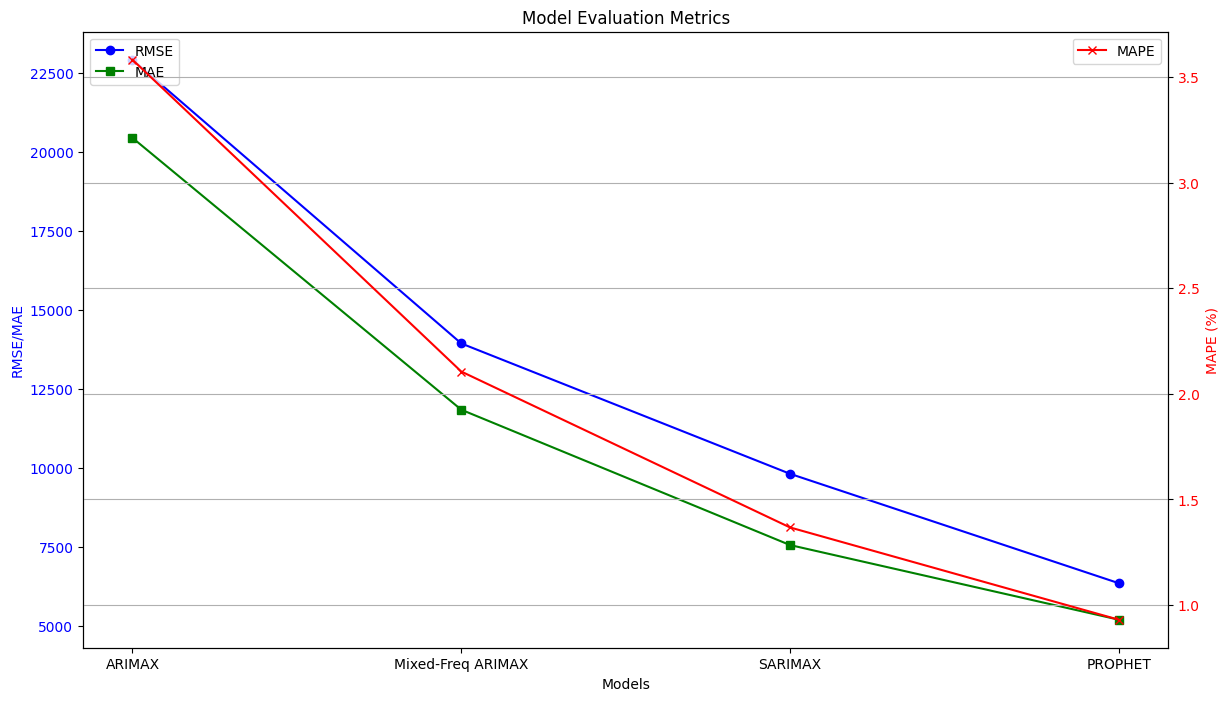

In [ ]:
# prompt: the mape metric is a percentage and is very small compared to rmse and mae. use a second y axis to show mape

import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(14, 8))

# Plot RMSE and MAE on the primary y-axis
ax1.plot(errors.index, errors['rmse'], label='RMSE', color='blue', marker='o')
ax1.plot(errors.index, errors['mae'], label='MAE', color='green', marker='s')
ax1.set_xlabel("Models")
ax1.set_ylabel("RMSE/MAE", color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.legend(loc='upper left')

# Create a second y-axis for MAPE
ax2 = ax1.twinx()
ax2.plot(errors.index, errors['mape'], label='MAPE', color='red', marker='x')
ax2.set_ylabel("MAPE (%)", color='red')
ax2.tick_params(axis='y', labelcolor='red')
ax2.legend(loc='upper right')

plt.title("Model Evaluation Metrics")
plt.grid()
plt.savefig("model_errors.jpg", dpi=300, bbox_inches="tight")
plt.show()